In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.models import Model
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import random

In [36]:
random.seed(237817)

# Setting these as global variables so that they can be shuffled to ensure an even distribution- many times I wasn't getting all 24/720 labels in the validation set

images = np.load("150/images.npy")
labels = np.load("150/labels.npy")

size = 150
images = np.load(f'{size}/images.npy')
total = 18000
split = int(total*0.8)

indices = np.random.permutation(images.shape[0])
shuffled_images = images[indices,:,:]
shuffled_labels = labels[indices,:]

train_images = shuffled_images[0:split,:,:]
train_labels = shuffled_labels[0:split,:]

test_images = shuffled_images[split:,:,:]
test_labels = shuffled_labels[split:,:]

valid_images = train_images[0:int(total*0.25),:,:]
valid_labels = train_labels[0:int(total*0.25),:]

# train_images = train_images[int(total*0.1):,:,:]
# train_labels = train_labels[int(total*0.1):,:]

train_images = train_images / 255.0
test_images = test_images / 255.0
valid_images = valid_images / 255.0

train_images = train_images.reshape(train_images.shape[0],150,150,1)
test_images  = test_images.reshape(test_images.shape[0],150,150,1)
valid_images = valid_images.reshape(valid_images.shape[0],150,150,1)

train_labels = train_labels.astype("float32")
test_labels = test_labels.astype("float32")
valid_labels = valid_labels.astype("float32")

train_hours = train_labels[:,0]
train_minutes = train_labels[:,1]
test_hours = test_labels[:,0]
test_minutes = test_labels[:,1]
valid_hours = valid_labels[:,0] 
valid_minutes = valid_labels[:,1]

print(train_images.shape, train_labels.shape)

# Convert the time into 24 separate labels
def conv_time_24(hours, minutes):
    h, m = int, float
    if minutes <= .50:
        h = int(hours)
        m = 0.5
    else:
      m = 0
      h = int(hours)
    
    return h, m

# Convert the time into 720 separate labels 
def conv_time_720(hour, minute):
    return hour*60, minute

y_train_converted = np.empty(int(total*0.8), dtype="float32")
y_test_converted = np.empty(int(total*0.2), dtype="float32")
y_valid_converted = np.empty(int(total*0.25), dtype="float32")

for i in range(len(train_hours)):
    hours, minutes = conv_time_720(train_hours[i], train_minutes[i]/60)
    y_train_converted[i] = hours + float(minutes)
    
for i in range(len(test_hours)):
    hours, minutes = conv_time_720(test_hours[i], test_minutes[i]/60)
    y_test_converted[i] = hours + float(minutes) 
    
for i in range(len(valid_hours)):   
    hours, minutes = conv_time_720(valid_hours[i], valid_minutes[i]/60)
    y_valid_converted[i] = hours + float(minutes)

encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test_converted)
y_train_encoded = encoder.fit_transform(y_train_converted)
y_valid_encoded = encoder.fit_transform(y_valid_converted)

(14400, 150, 150, 1) (14400, 2)


## Classification Model

In [37]:

OH_Encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = OH_Encoder.fit_transform(y_train_encoded.reshape(-1, 1))
onehot_encoded_valid = OH_Encoder.fit_transform(y_valid_encoded.reshape(-1, 1))

In [38]:
import tensorflow.keras.backend as K

#Common sense error function- checks the smaller of the differences by converting to military time
def common_sense_error_classification(true, pred):
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+12-true)
    return K.minimum(diff1, diff2)

In [41]:
np.random.seed(9999)


# Classification CNN
input_shape=(images.shape[1], images.shape[2], 1)
print(train_images.shape, onehot_encoded.shape, input_shape, onehot_encoded_valid.shape)

model_classification = tf.keras.models.Sequential()
model_classification.add(Input(shape=input_shape))
model_classification.add(Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model_classification.add(Conv2D(activation="relu", filters=32, kernel_size=(3,3), input_shape=input_shape))
model_classification.add(MaxPooling2D(pool_size=2))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=32))
model_classification.add(MaxPooling2D(pool_size=2))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=64))
model_classification.add(Conv2D(kernel_size=(3,3), activation="relu", filters=64))


model_classification.add(Flatten())
model_classification.add(Dense(units=1024, activation="relu"))
model_classification.add(Dense(units=512, activation="relu"))
model_classification.add(Dense(units=512, activation="relu"))
model_classification.add(Dense(units=256, activation="relu"))
model_classification.add(Dense(units=256, activation="relu"))
model_classification.add(Dense(units=128, activation="relu"))
model_classification.add(Dense(units=64, activation="relu"))
model_classification.add(Dense(units=32, activation="relu"))
model_classification.add(Dense(units=720, activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_classification.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 15)

(14400, 150, 150, 1) (14400, 720) (150, 150, 1) (4500, 720)


In [42]:
print(train_images.shape, onehot_encoded.shape)

cl_h = model_classification.fit(train_images, onehot_encoded, epochs=50, batch_size=180, validation_data=(valid_images, onehot_encoded_valid))

(14400, 150, 150, 1) (14400, 720)
Epoch 1/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.0012 - loss: 6.5793 - val_accuracy: 8.8889e-04 - val_loss: 6.5792
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - accuracy: 0.0012 - loss: 6.5792 - val_accuracy: 0.0013 - val_loss: 6.5791
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 5.8910e-04 - loss: 6.5792 - val_accuracy: 0.0013 - val_loss: 6.5791
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 13s 163ms/step - accuracy: 0.0022 - loss: 6.5792 - val_accuracy: 0.0013 - val_loss: 6.5790
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 0.0019 - loss: 6.5791 - val_accuracy: 0.0013 - val_loss: 6.5790
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - accuracy: 0.0017 - loss: 6.5790 - val_accuracy: 0.0013 - val_loss: 6.5789
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 15s 182ms/step - accuracy: 0.0014 - loss: 6.5790 - val_accuracy: 4.4444e-04 - val_loss: 6.5788
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/ste

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


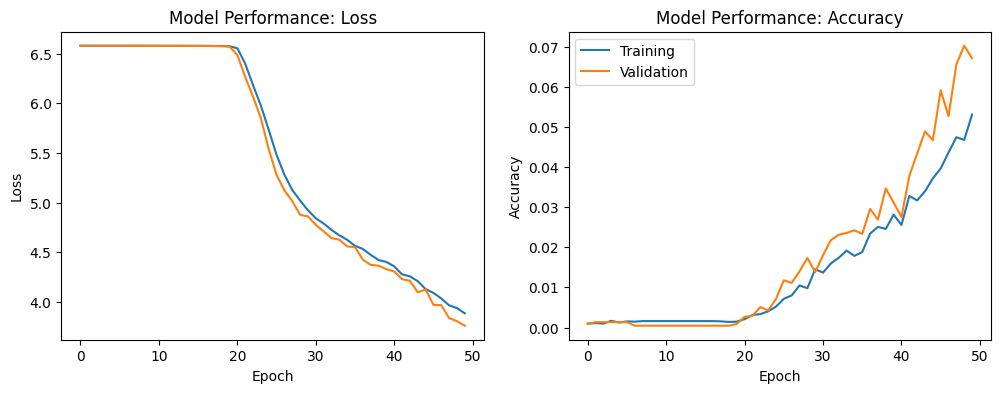

In [44]:
# Graph the model training
f, ax = plt.subplots(1, 2, figsize=(12, 4))
print(cl_h.history.keys())
ax[0].plot(cl_h.history['loss'])
ax[0].plot(cl_h.history['val_loss'])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Performance: Loss')
ax[1].legend(['Training', 'Validation'], loc='upper left')

ax[1].plot(cl_h.history['accuracy'])
ax[1].plot(cl_h.history['val_accuracy'])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Model Performance: Accuracy')
ax[1].legend(['Training', 'Validation'], loc='upper left')

In [45]:
# Measuring accuracy- picking the highest confidence label and comparing it to the true label
predicted = model_classification.predict(test_images)
predicted = np.argmax(predicted, axis=1)
print(predicted)
print(y_test_encoded)
print(np.sum(predicted == y_test_encoded) / len(y_test_encoded) * 100, "%")
average_error_time_classification = np.sum(common_sense_error_classification(y_test_encoded, predicted))/ len(test_images)
print(average_error_time_classification)
hour_accuracy = int(average_error_time_classification // 1)
if average_error_time_classification % 1 > 0.5:
    print("Average common sense error is between", str(hour_accuracy)+".5 and", hour_accuracy+1, "hours")
else:
    print("Average common sense error is between", str(hour_accuracy), "and", hour_accuracy+0.5, "hours")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
[713 602 431 ... 222 602 540]
[656 265 427 ...  40 376 329]
1.7222222222222223 %
162.20277777777778
Average common sense error is between 162 and 162.5 hours


## Regression Model

In [ ]:
import tensorflow.keras.backend as K

#returning the common sense difference between two times
def common_sense_error(true, pred):
    true = K.cast(true, 'float32')
    diff_1 = K.abs(true - pred)
    diff_2 = K.abs(true - (pred + 12))

    return K.minimum(diff_1, diff_2)

In [ ]:
# Convert the time into a continuous value
def conv_time(time):
    return time[0] + time[1]/60

train_labels_reg = np.array([conv_time(time) for time in train_labels])
test_labels_reg = np.array([conv_time(time) for time in test_labels])
val_labels_reg = np.array([conv_time(time) for time in valid_labels])

model_regression = tf.keras.models.Sequential()

model_regression.add(Conv2D(kernel_size=(5,5), strides = (2,2), activation="relu", filters=32))
model_regression.add(Conv2D(activation='relu', filters=32, kernel_size=(3,3), input_shape=(75, 75, 1)))
model_regression.add(MaxPooling2D(pool_size=2))
model_regression.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model_regression.add(Conv2D(filters=32 ,kernel_size=(3,3), activation='relu'))
model_regression.add(MaxPooling2D(pool_size=2))
model_regression.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_regression.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model_regression.add(MaxPooling2D(pool_size=2))


model_regression.add(Flatten())
model_regression.add(Dense(units=1024, activation='relu'))
model_regression.add(Dense(units=512, activation='relu'))
model_regression.add(Dense(units=512, activation='relu'))
model_regression.add(Dense(units=256, activation='relu'))
model_regression.add(Dense(units=256, activation='relu'))
model_regression.add(Dense(units=128, activation='relu'))
model_regression.add(Dense(units=64, activation='relu'))
model_regression.add(Dense(units=32, activation='relu'))
model_regression.add(Dense(units=16, activation='relu'))
model_regression.add(Dense(units=1, activation="softplus"))
model_regression.compile(loss="mse", optimizer="adam", metrics=[common_sense_error, "mae"])

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

r_h = model_regression.fit(train_images, train_labels_reg, epochs=50, batch_size = 512, validation_data = (valid_images, val_labels_reg), callbacks = [early_stop])

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - common_sense_error: 3.0481 - loss: 28.9560 - mae: 4.4144 - val_common_sense_error: 3.0061 - val_loss: 12.3770 - val_mae: 3.0288
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - common_sense_error: 2.9823 - loss: 12.0194 - mae: 2.9918 - val_common_sense_error: 2.9915 - val_loss: 12.0624 - val_mae: 2.9971
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - common_sense_error: 3.0168 - loss: 12.2380 - mae: 3.0216 - val_common_sense_error: 2.9690 - val_loss: 11.7519 - val_mae: 2.9652
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - common_sense_error: 3.0177 - loss: 12.0985 - mae: 3.0162 - val_common_sense_error: 2.9597 - val_loss: 11.6609 - val_mae: 2.9527
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - common_sense_error: 3.0179 - loss: 12.2233 - mae: 3.0177 - val_common_sense_error: 2.9601 - val_loss: 11.6639 - val_mae: 2.9510
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - common_sense_error: 3.0041 - loss: 12.0636

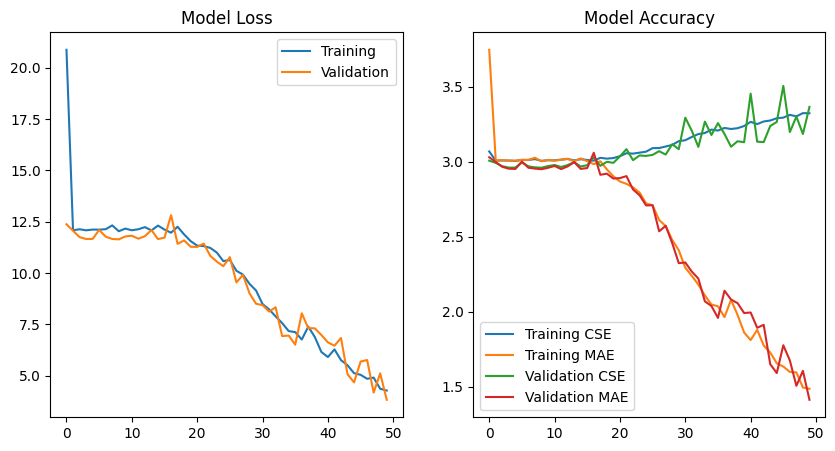

In [ ]:
# Graph the model training
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].plot(r_h.history["loss"])
ax[0].plot(r_h.history["val_loss"])
ax[0].legend(["Training", "Validation"])
ax[0].set_title("Model Loss")

ax[1].set_title("Model Accuracy")
ax[1].plot(r_h.history["common_sense_error"])
ax[1].plot(r_h.history["mae"])
ax[1].plot(r_h.history["val_common_sense_error"])
ax[1].plot(r_h.history["val_mae"])
ax[1].legend(["Training CSE", "Training MAE", "Validation CSE", "Validation MAE"])
plt.show()

In [ ]:
# Measuring accuracy within 1 minute of the true time
reg_preds = model_regression.predict(test_images)
total_error_time = 0
for i in range(len(test_images)):
    error = float(common_sense_error(test_labels_reg[i], reg_preds[i]))
    total_error_time += round(error, 4)
average_error_time = round(total_error_time/len(test_images), 4)
print("Average common sense error is", average_error_time//1, "hours", (average_error_time%1)*60, "minutes")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Average common sense error is 1.0 hours 31.127999999999997 minutes


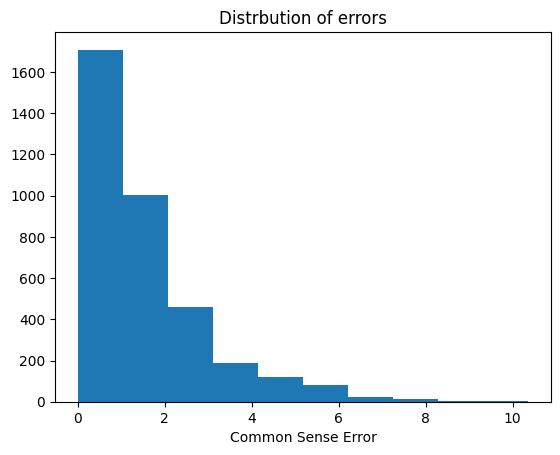

In [ ]:
errors = [round(float(common_sense_error(test_labels_reg[i], reg_preds[i])), 4) for i in range(len(test_images))]
plt.hist(errors)
plt.title("Distrbution of errors")
plt.xlabel("Common Sense Error")
plt.show()

## Two-Headed Model

In [46]:
import tensorflow.keras.backend as K

def common_sense_hour(true, pred):
    diff1 = abs(pred-true)
    diff2 = abs(pred+12-true)
    return min(diff1, diff2)

def common_sense_minute(true, pred):
    true = K.cast(true, 'float32')
    diff1 = K.abs(pred-true)
    diff2 = K.abs(pred+60-true)
    return K.minimum(diff1, diff2)

In [47]:
OH_Encoder = OneHotEncoder(sparse_output=False)
two_head_train_hours = OH_Encoder.fit_transform(train_hours.reshape(-1, 1))
two_head_val_hours = OH_Encoder.fit_transform(valid_hours.reshape(-1, 1))

In [48]:
inp = Input(shape = (150,150,1))

two_head_model = Conv2D(32,kernel_size = (5,5), strides= (2,2), activation = "relu")(inp)
two_head_model = MaxPooling2D(pool_size =2)(two_head_model)
two_head_model = Conv2D(32,kernel_size = (3,3),activation = "relu")(two_head_model)
two_head_model = Conv2D(32,kernel_size = (3,3),activation = "relu")(two_head_model)
two_head_model = MaxPooling2D(pool_size =2)(two_head_model)
two_head_model = Conv2D(64,kernel_size = (3,3),activation = "relu")(two_head_model)
two_head_model = Conv2D(64,kernel_size = (1,1),activation = "relu")(two_head_model)
two_head_model = Flatten()(two_head_model)

d = Dense(512,activation = "relu")(two_head_model)
d = Dense(512,activation = "relu")(d)
d = tf.keras.layers.Dropout(0.1)(d)
d = Dense(256,activation = "relu")(d)

# The hour head predicts confidence amonst 12 label classes- one for each hour 
hour = Dense(256,activation = "relu")(d)
hour = Dense(128,activation = "relu")(hour)
hour = Dense(64,activation = "relu")(hour)
hour = Dense(32,activation = "relu")(hour)
hour = Dense(16,activation = "relu")(hour)
hour = Dense(12,activation= "softmax", name= "hour")(hour)

# The minute head runs a regression on a continuous value
minute = Dense(256,activation = "relu")(d)
minute = Dense(256,activation = "relu")(minute)
minute = Dense(256,activation = "relu")(minute)
minute = Dense(128,activation = "relu")(minute)
minute = Dense(64,activation = "relu")(minute)
minute = Dense(32,activation = "relu")(minute)
minute = Dense(16,activation = "relu")(minute)
minute = Dense(1, activation = "softplus", name = "minute")(minute)

model = tf.keras.models.Model(inputs=inp, outputs=[hour, minute])
optim = tf.keras.optimizers.Adam()
model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=optim, metrics=['accuracy',"mae"])

print(train_hours.shape, train_minutes.shape, train_images.shape, valid_hours.shape)

early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)
th_h = model.fit(train_images, [two_head_train_hours, train_minutes/60], epochs=30, batch_size = 512, validation_data = (valid_images, [two_head_val_hours, valid_minutes/60]))

(14400,) (14400,) (14400, 150, 150, 1) (4500,)
Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - hour_accuracy: 0.0786 - hour_loss: 2.4856 - loss: 2.5847 - minute_loss: 0.0991 - minute_mae: 0.2664 - val_hour_accuracy: 0.0891 - val_hour_loss: 2.4850 - val_loss: 2.5692 - val_minute_loss: 0.0843 - val_minute_mae: 0.2518
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - hour_accuracy: 0.0815 - hour_loss: 2.4850 - loss: 2.5687 - minute_loss: 0.0837 - minute_mae: 0.2509 - val_hour_accuracy: 0.0847 - val_hour_loss: 2.4849 - val_loss: 2.5686 - val_minute_loss: 0.0837 - val_minute_mae: 0.2512
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - hour_accuracy: 0.0877 - hour_loss: 2.4847 - loss: 2.5680 - minute_loss: 0.0833 - minute_mae: 0.2496 - val_hour_accuracy: 0.0847 - val_hour_loss: 2.4849 - val_loss: 2.5688 - val_minute_loss: 0.0840 - val_minute_mae: 0.2514
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - hour_accuracy: 0.0813 - hour_loss: 2.4850 - loss: 2.5690 - minute_loss:

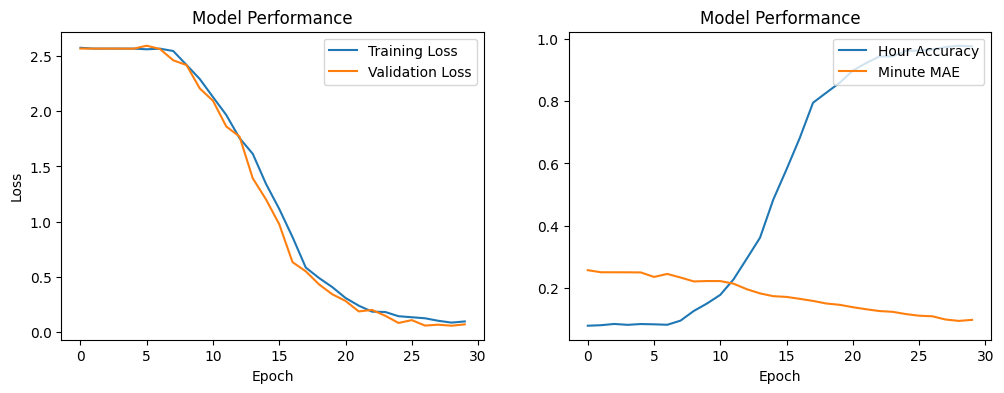

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))


ax[0].plot(th_h.history['loss'])
ax[0].plot(th_h.history['val_loss'])
ax[0].set_title('Model Performance')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(['Training Loss', 'Validation Loss'], loc='upper right')

ax[1].plot(th_h.history['hour_accuracy'])
ax[1].plot(th_h.history['minute_mae'])
ax[1].set_title('Model Performance')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('')
ax[1].legend(['Hour Accuracy', 'Minute MAE'], loc='upper right')

plt.show()


In [50]:
predictions = model.predict(test_images)
predicted_hours = np.argmax(predictions[0], axis=-1)
predicted_mins = np.argmax(predictions[1], axis=-1)
hour_diff = 0
minute_diff = 0
for i in range(len(test_images)):
    hour_diff += int(common_sense_hour(test_hours[i], predicted_hours[i]))
    minute_diff += float(common_sense_minute(test_minutes[i], predicted_mins[i]))
print("Average error is", int(hour_diff/len(test_images)), "hrs", round(minute_diff/len(test_images), 3), "mins")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Average error is 0 hrs 15.131 mins
